In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display

In [2]:
def compute_ivt(q,v,p):
    g = 9.81
    pres_ = np.copy(p)
    pres_[pres_<25000] = np.nan # 900hPa to 300hPa in theory but extended to include enough model levels
    dp_ = np.append(np.diff(pres_),np.nan)
    dp_[np.isnan(dp_)]=0.0
    dp_=np.repeat(dp_[np.newaxis,:],q.shape[0],axis=0)
    dp_=np.repeat(dp_[:,:,np.newaxis],q.shape[2],axis=2)
    dp_=np.repeat(dp_[:,:,:,np.newaxis],q.shape[3],axis=3)
    p_ = pres_
    q_ = q
    v_ = v
    iv_ = -1/g*np.sum(q_*v_*dp_,axis=1)
    return iv_

In [3]:
def compute_ivt1(ivx):
    g = 9.81
    iv_ = -1/g*ivx.qv.integrate(coord='plev')
    return iv_

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [5]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['hus','va'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,day,hus,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815
1,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,day,va,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815


In [6]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [7]:
dataset_list = list(dset_dict.keys())

['CMIP.NCC.NorESM2-LM.historical.day.gn']

In [8]:
dset = dset_dict[dataset_list[0]]
dset = dset.sel(member_id='r1i1p1f1',time=slice("2014-01-01", "2014-12-31"))
dset

<xarray.Dataset>
Dimensions:    (lat: 96, lon: 144, plev: 8, time: 365, bnds: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * time       (time) object 2014-01-01 12:00:00 ... 2014-12-31 12:00:00
    member_id  <U8 'r1i1p1f1'
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(365, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    hus        (time, plev, lat, lon) float32 dask.array<chunksize=(66, 8, 96, 144), meta=np.ndarray>
    va         (time, plev, lat, lon) float32 dask.array<chunksize=(92, 8, 96, 144), meta=np.ndarray>
Attributes: (12/50)
    source_type:               AOGCM
    sub_experiment_id:         none
    data_specs_version:        01.00.31
    variant_label:             r1i1p1f1
    run_variant:               N/A
    parent_variant_label:      r1i1p1f1
    ...                        ...
    experiment:                all-forcing simulation of the recent past
    parent_sub_experiment_id:  none
    realm:                     atmos
    license:                   CMIP6 model data produced by NCC is licensed u...
    physics_index:             1
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.historical.day.gn

In [34]:
vas = dset.va
hus = dset.hus
plev = dset.plev
dset['qv'] = dset.va*dset.hus
qv = dset.qv
qv = xr.where(qv.plev>=25000,qv,0)
dset['qv'] = qv
lat_ = hus.lat
lon_ = hus.lon

In [35]:
qv

<xarray.DataArray (plev: 8, time: 365, lat: 96, lon: 144)>
dask.array<where, shape=(8, 365, 96, 144), dtype=float32, chunksize=(8, 140, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
    member_id  <U8 'r1i1p1f1'
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) object 2014-01-01 12:00:00 ... 2014-12-31 12:00:00

In [36]:
ivt1 = compute_ivt1(dset)

In [37]:
ivt = compute_ivt(hus,vas,plev)

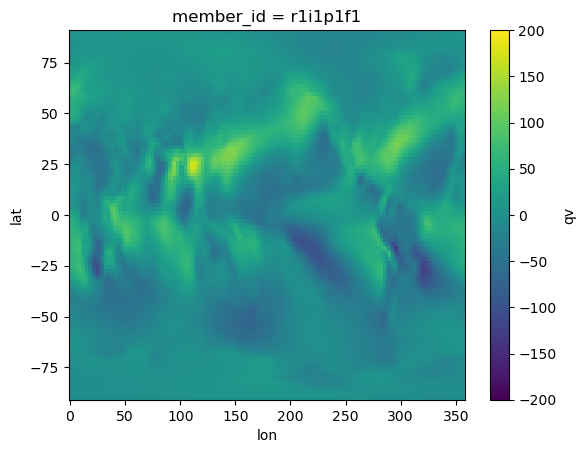

In [38]:
ivt1.mean(dim='time').plot.pcolormesh(vmin=-200,vmax=200)

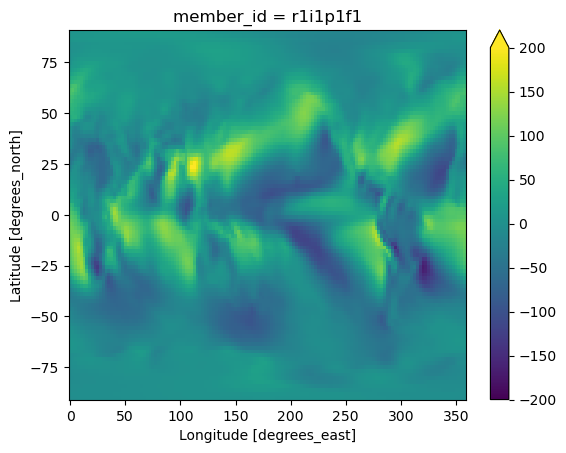

In [32]:
ivt.mean(dim='time').plot.pcolormesh(vmin=-200,vmax=200)

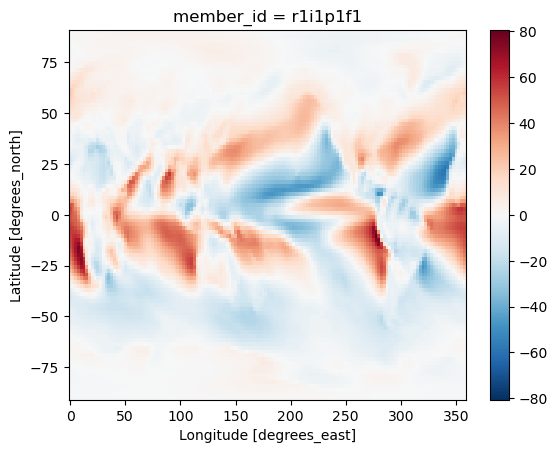

In [33]:
xr.plot.pcolormesh(ivt.mean(dim='time')-ivt1.mean(dim='time'))

In [1]:
ivt_ns = ivt.copy()
ivt_ns = xr.where(ivt_ns.lat<0,-ivt_ns,ivt_ns,True) # minus for southern hemisphere (positive toward the pole)
ivt_ns_pos = xr.where(ivt_ns<0,ivt_ns*0,ivt_ns,True) # negative values = not poleward
ivt_ns_pos

NameError: name 'ivt' is not defined

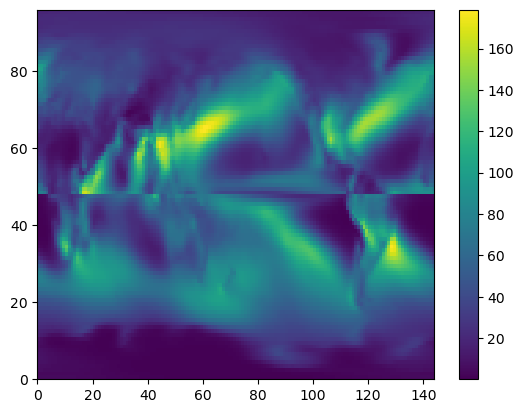

In [36]:
plt.pcolormesh(ivt_ns_pos.mean(dim='time'))
plt.colorbar()
plt.show()

In [60]:
q98 = ivt_ns_pos.chunk(dict(time=-1)).quantile(0.98,'time')

<xarray.DataArray 'lat' (lat: 96, lon: 144)>
dask.array<getitem, shape=(96, 144), dtype=float64, chunksize=(96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    quantile  float64 0.98
(96, 5475, 144)


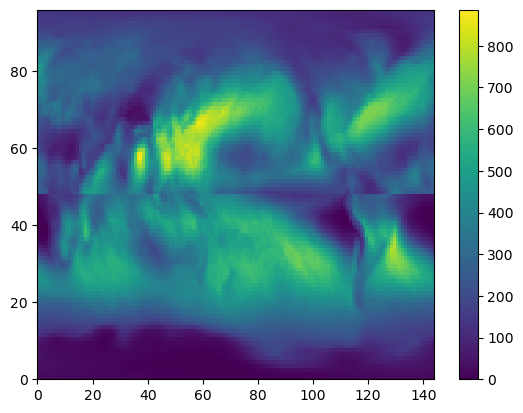

In [43]:
plt.pcolormesh(q98)
plt.colorbar()
plt.show()